# loading packages 

In [7]:
#!pip install evaluate
#!pip install tensorflow
#!pip install tf_keras

In [8]:


import pandas as pd
import nltk
import matplotlib 
from transformers import DistilBertForSequenceClassification, TrainingArguments, Trainer
import evaluate
import numpy as np
import torch.nn as nn
import tensorflow as tf
import tf_keras as keras


import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast
from datasets import Dataset, Features, Value, ClassLabel, Sequence
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoConfig



2025-04-28 16:10:10.986063: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-28 16:10:11.013267: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745871011.044929  117425 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745871011.054159  117425 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745871011.077610  117425 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

# data loading

## Berkeley Data Loading & Preprocessing

In [9]:



berkeley = pd.read_parquet("hf://datasets/ucberkeley-dlab/measuring-hate-speech/measuring-hate-speech.parquet")

columns_relevant =  ['hatespeech', 'text', 'target_race_asian', 'target_race_black', 'target_race_latinx', 'target_race_middle_eastern',
'target_race_native_american', 'target_race_pacific_islander', 'target_race_white', 'target_religion_atheist', 'target_religion_buddhist',
'target_religion_christian', 'target_religion_hindu', 'target_religion_jewish', 'target_religion_mormon', 'target_religion_muslim', 
'target_religion_other', 'target_origin_immigrant', 'target_origin_migrant_worker', 'target_origin_undocumented', 
'target_gender_men', 'target_gender_non_binary', 'target_gender_transgender_men', 'target_gender_transgender_unspecified',
'target_gender_transgender_women', 'target_gender_women', 'target_sexuality_bisexual', 'target_sexuality_gay', 'target_sexuality_lesbian',
'target_sexuality_straight', 'target_sexuality_other', 'target_disability_physical', 'target_disability_cognitive',
'target_disability_neurological', 'target_disability_visually_impaired', 'target_disability_hearing_impaired', 'target_disability_unspecific',
'target_disability_other']

berkeley_columns_relevant = berkeley[columns_relevant]
berkeley_columns_relevant.head()

,hatespeech,text,target_race_asian,target_race_black,target_race_latinx,target_race_middle_eastern,target_race_native_american,target_race_pacific_islander,target_race_white,target_religion_atheist,...,target_sexuality_lesbian,target_sexuality_straight,target_sexuality_other,target_disability_physical,target_disability_cognitive,target_disability_neurological,target_disability_visually_impaired,target_disability_hearing_impaired,target_disability_unspecific,target_disability_other
0,0.0,Yes indeed. She sort of reminds me of the elde...,True,True,True,True,True,True,True,False,...,False,False,False,False,False,False,False,False,False,False
1,0.0,The trans women reading this tweet right now i...,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,2.0,Question: These 4 broads who criticize America...,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,0.0,It is about time for all illegals to go back t...,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,2.0,For starters bend over the one in pink and kic...,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### remove non-hate

In [10]:
berkely_hate = berkeley_columns_relevant[berkeley_columns_relevant['hatespeech'] > 0]
berkely_hate



,hatespeech,text,target_race_asian,target_race_black,target_race_latinx,target_race_middle_eastern,target_race_native_american,target_race_pacific_islander,target_race_white,target_religion_atheist,...,target_sexuality_lesbian,target_sexuality_straight,target_sexuality_other,target_disability_physical,target_disability_cognitive,target_disability_neurological,target_disability_visually_impaired,target_disability_hearing_impaired,target_disability_unspecific,target_disability_other
2,2.0,Question: These 4 broads who criticize America...,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,2.0,For starters bend over the one in pink and kic...,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6,2.0,Who the fuck is this insignificant simple mind...,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
7,2.0,Fuck off you insufferable retarded faggot.,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9,2.0,"Worthless whore, these tits with look nice wit...",False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135523,1.0,"Lady in the back Blinks when ""her"" camera red ...",False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
135546,1.0,🔥PUBG JAPAN SERIES 🔥Grade2 Day2 6/7 <Round8> 1...,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
135547,1.0,لا تتشمت الرجال مسكين يعاني كس امه 😂. يقول يال...,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
135548,1.0,#DSSUpliftsTheThirdGender #EmancipationOfEunuc...,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### merging columns

In [11]:
lgb_cols = [ 'target_sexuality_bisexual', 'target_sexuality_gay', 'target_sexuality_lesbian', 'target_sexuality_other']

t_cols = ['target_gender_transgender_men', 'target_gender_transgender_unspecified','target_gender_transgender_women']

disability_cols = ['target_disability_physical', 'target_disability_cognitive', 'target_disability_neurological',
'target_disability_visually_impaired', 'target_disability_hearing_impaired', 'target_disability_unspecific', 'target_disability_other']

immigrant_cols = ['target_origin_immigrant', 'target_origin_migrant_worker', 'target_origin_undocumented']


berkely_hate.loc[:, 'Transgender'] = berkely_hate[t_cols].any(axis=1)
berkely_hate.loc[:, 'LGB+'] = berkely_hate[lgb_cols].any(axis=1)
berkely_hate.loc[:, 'Disabled'] = berkely_hate[disability_cols].any(axis=1)
berkely_hate.loc[:, 'Immigrant'] = berkely_hate[immigrant_cols].any(axis=1)


berkely_hate = berkely_hate.copy()
berkely_hate.rename(columns={'target_race_asian': 'Asian', 'target_race_black': 'Black', 'target_race_latinx': 'Latinx', 
'target_race_middle_eastern': 'Middle Eastern', 'target_race_pacific_islander': 'Pacific Islander', 'target_race_white': 'White', 
'target_religion_atheist': 'Atheist', 'target_religion_buddhist': 'Buddhist', 'target_religion_christian':'Christian','target_religion_hindu': 'Hindu', 
'target_religion_jewish': 'Jewish','target_religion_mormon': 'Mormon',
'target_religion_muslim': 'Muslim', 'target_religion_other': 'Other Religion', 'target_gender_men': 'Men', 
'target_gender_non_binary': 'Non-Binary', 'target_gender_women': 'Women', 'target_sexuality_straight': 'Straight', 'target_race_native_american': 'Native American',
}, inplace=True)

berkeley_compressed = berkely_hate.drop(lgb_cols + t_cols + disability_cols + immigrant_cols, axis=1)

berkeley_compressed['hatespeech'] = berkeley_compressed['hatespeech'].apply(lambda x: 1 if x > 0 else 0)
berkeley_compressed

/scratch/slurm-14097/ipykernel_117425/2584169070.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  berkely_hate.loc[:, 'Transgender'] = berkely_hate[t_cols].any(axis=1)
/scratch/slurm-14097/ipykernel_117425/2584169070.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  berkely_hate.loc[:, 'LGB+'] = berkely_hate[lgb_cols].any(axis=1)
/scratch/slurm-14097/ipykernel_117425/2584169070.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

,hatespeech,text,Asian,Black,Latinx,Middle Eastern,Native American,Pacific Islander,White,Atheist,...,Muslim,Other Religion,Men,Non-Binary,Women,Straight,Transgender,LGB+,Disabled,Immigrant
2,1,Question: These 4 broads who criticize America...,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,1,For starters bend over the one in pink and kic...,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
6,1,Who the fuck is this insignificant simple mind...,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
7,1,Fuck off you insufferable retarded faggot.,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
9,1,"Worthless whore, these tits with look nice wit...",False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135523,1,"Lady in the back Blinks when ""her"" camera red ...",False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
135546,1,🔥PUBG JAPAN SERIES 🔥Grade2 Day2 6/7 <Round8> 1...,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
135547,1,لا تتشمت الرجال مسكين يعاني كس امه 😂. يقول يال...,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
135548,1,#DSSUpliftsTheThirdGender #EmancipationOfEunuc...,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### creating graph

,Asian,Black,Latinx,Middle Eastern,Native American,Pacific Islander,White,Atheist,Buddhist,Christian,...,Mormon,Other Religion,Men,Non-Binary,Women,Straight,LGB+,Transgender,Disabled,Immigrant
Nonhate,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Hate,3651,13699,4370,4464,679,696,3692,254,202,1173,...,237,599,3038,484,10693,1484,7804,1497,2365,5586


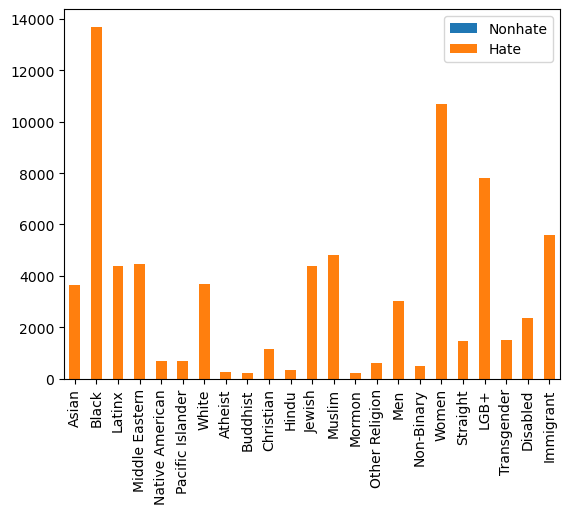

In [12]:
columns_to_sum = ['Asian', 'Black', 'Latinx', 'Middle Eastern', 'Native American', 'Pacific Islander', 'White', 'Atheist', 'Buddhist', 'Christian','Hindu', 'Jewish', 'Muslim', 'Mormon', 'Other Religion', 'Men', 'Non-Binary', 'Women', 'Straight', 'LGB+','Transgender', 'Disabled', 'Immigrant']






hate_counts = berkeley_compressed[columns_to_sum].where(berkeley_compressed['hatespeech'] == 1).sum().to_frame().T
nonhate_counts = berkeley_compressed[columns_to_sum].where(berkeley_compressed['hatespeech'] == 0).sum().to_frame().T

target_counts = pd.concat([nonhate_counts, hate_counts], ignore_index=True)
target_counts.index = ['Nonhate', 'Hate']


target_counts.T.plot.bar(stacked=True)
target_counts.head()


### multi_lable to multiclass

### removing low-frequency identities

In [13]:
#removing native american, pacific islander, athiest, buddhist,  hindu, mormon, other religions, non-binary
high_frequency_targets = berkeley_compressed.drop(['Native American', 'Pacific Islander', 'Atheist', 'Buddhist', 
                                                     'Hindu', 'Mormon', 'Other Religion', 'Non-Binary', 'Straight'], axis = 1)
high_frequency_targets

,hatespeech,text,Asian,Black,Latinx,Middle Eastern,White,Christian,Jewish,Muslim,Men,Women,Transgender,LGB+,Disabled,Immigrant
2,1,Question: These 4 broads who criticize America...,False,False,False,False,False,False,False,False,False,False,False,False,False,True
4,1,For starters bend over the one in pink and kic...,False,False,False,False,False,False,False,False,False,True,False,False,False,False
6,1,Who the fuck is this insignificant simple mind...,False,False,False,False,True,False,False,False,False,False,False,False,False,False
7,1,Fuck off you insufferable retarded faggot.,False,False,False,False,False,False,False,False,False,False,False,True,False,False
9,1,"Worthless whore, these tits with look nice wit...",False,False,False,False,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135523,1,"Lady in the back Blinks when ""her"" camera red ...",False,False,False,False,False,False,False,False,False,False,False,True,False,False
135546,1,🔥PUBG JAPAN SERIES 🔥Grade2 Day2 6/7 <Round8> 1...,False,False,False,False,False,False,False,False,False,False,False,False,False,False
135547,1,لا تتشمت الرجال مسكين يعاني كس امه 😂. يقول يال...,False,False,False,False,False,False,False,False,False,False,False,False,False,False
135548,1,#DSSUpliftsTheThirdGender #EmancipationOfEunuc...,False,False,False,True,False,False,False,False,False,False,False,False,False,False


### removing doubles

In [14]:
num_identities = high_frequency_targets.loc[:,"Asian":"Immigrant"].sum(axis = 1)
#print(num_identities)
num_identities

multi_identities = num_identities > 1
no_identities = num_identities == 0

berkely_dropped_none =high_frequency_targets[~no_identities]
berkely_dropped_multi = berkely_dropped_none[~multi_identities]

berkely_dropped_multi

/scratch/slurm-14097/ipykernel_117425/868952246.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  berkely_dropped_multi = berkely_dropped_none[~multi_identities]


,hatespeech,text,Asian,Black,Latinx,Middle Eastern,White,Christian,Jewish,Muslim,Men,Women,Transgender,LGB+,Disabled,Immigrant
2,1,Question: These 4 broads who criticize America...,False,False,False,False,False,False,False,False,False,False,False,False,False,True
4,1,For starters bend over the one in pink and kic...,False,False,False,False,False,False,False,False,False,True,False,False,False,False
6,1,Who the fuck is this insignificant simple mind...,False,False,False,False,True,False,False,False,False,False,False,False,False,False
7,1,Fuck off you insufferable retarded faggot.,False,False,False,False,False,False,False,False,False,False,False,True,False,False
9,1,"Worthless whore, these tits with look nice wit...",False,False,False,False,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135406,1,"Lady in the back Blinks when ""her"" camera red ...",False,False,False,False,False,False,False,False,False,False,False,True,False,False
135435,1,"Lady in the back Blinks when ""her"" camera red ...",False,False,False,False,False,False,False,False,False,False,True,False,False,False
135515,1,"Lady in the back Blinks when ""her"" camera red ...",False,False,False,False,False,False,False,False,False,False,True,False,False,False
135523,1,"Lady in the back Blinks when ""her"" camera red ...",False,False,False,False,False,False,False,False,False,False,False,True,False,False


### changing to multi class

In [15]:

#multi_class_dummy = high_frequency_targets.astype(int)
multi_class_column = pd.from_dummies(berkely_dropped_multi.loc[:,'Asian':'Immigrant'])
multi_class_column

,
2,Immigrant
4,Women
6,White
7,LGB+
9,Women
...,...
135406,LGB+
135435,Transgender
135515,Transgender
135523,LGB+


In [16]:
multi_class = pd.concat([berkely_dropped_multi,multi_class_column], axis = 1)
multi_class

,hatespeech,text,Asian,Black,Latinx,Middle Eastern,White,Christian,Jewish,Muslim,Men,Women,Transgender,LGB+,Disabled,Immigrant,
2,1,Question: These 4 broads who criticize America...,False,False,False,False,False,False,False,False,False,False,False,False,False,True,Immigrant
4,1,For starters bend over the one in pink and kic...,False,False,False,False,False,False,False,False,False,True,False,False,False,False,Women
6,1,Who the fuck is this insignificant simple mind...,False,False,False,False,True,False,False,False,False,False,False,False,False,False,White
7,1,Fuck off you insufferable retarded faggot.,False,False,False,False,False,False,False,False,False,False,False,True,False,False,LGB+
9,1,"Worthless whore, these tits with look nice wit...",False,False,False,False,False,False,False,False,False,True,False,False,False,False,Women
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135406,1,"Lady in the back Blinks when ""her"" camera red ...",False,False,False,False,False,False,False,False,False,False,False,True,False,False,LGB+
135435,1,"Lady in the back Blinks when ""her"" camera red ...",False,False,False,False,False,False,False,False,False,False,True,False,False,False,Transgender
135515,1,"Lady in the back Blinks when ""her"" camera red ...",False,False,False,False,False,False,False,False,False,False,True,False,False,False,Transgender
135523,1,"Lady in the back Blinks when ""her"" camera red ...",False,False,False,False,False,False,False,False,False,False,False,True,False,False,LGB+


In [17]:
multi_class.columns.values[16] = "label"

multi_class

,hatespeech,text,Asian,Black,Latinx,Middle Eastern,White,Christian,Jewish,Muslim,Men,Women,Transgender,LGB+,Disabled,Immigrant,label
2,1,Question: These 4 broads who criticize America...,False,False,False,False,False,False,False,False,False,False,False,False,False,True,Immigrant
4,1,For starters bend over the one in pink and kic...,False,False,False,False,False,False,False,False,False,True,False,False,False,False,Women
6,1,Who the fuck is this insignificant simple mind...,False,False,False,False,True,False,False,False,False,False,False,False,False,False,White
7,1,Fuck off you insufferable retarded faggot.,False,False,False,False,False,False,False,False,False,False,False,True,False,False,LGB+
9,1,"Worthless whore, these tits with look nice wit...",False,False,False,False,False,False,False,False,False,True,False,False,False,False,Women
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135406,1,"Lady in the back Blinks when ""her"" camera red ...",False,False,False,False,False,False,False,False,False,False,False,True,False,False,LGB+
135435,1,"Lady in the back Blinks when ""her"" camera red ...",False,False,False,False,False,False,False,False,False,False,True,False,False,False,Transgender
135515,1,"Lady in the back Blinks when ""her"" camera red ...",False,False,False,False,False,False,False,False,False,False,True,False,False,False,Transgender
135523,1,"Lady in the back Blinks when ""her"" camera red ...",False,False,False,False,False,False,False,False,False,False,False,True,False,False,LGB+


In [68]:
berkely_dropped_multi.iloc[7]

hatespeech                                                        1
text              Get rid of them and their anchor babies and gr...
Asian                                                         False
Black                                                         False
Latinx                                                        False
Middle Eastern                                                False
White                                                         False
Christian                                                     False
Jewish                                                        False
Muslim                                                        False
Men                                                           False
Women                                                         False
Transgender                                                   False
LGB+                                                          False
Disabled                                        

## arabic data

In [79]:
arabic_data = pd.read_csv('levantine_arabic.csv',sep = ",")
arabic_data

,Tweet,Class,english
0,الوزير جبران باسيل تاج راسك يا جربان ممنوع بعد...,abusive,"Minister Gebran Bassil, crown your head, O Sco..."
1,صديقي انت ابن جامعه اللعبه اكبر من داعش اللعبه...,normal,"My friend, you are a university student. The g..."
2,و مصلحة لبنان تبدأ باستخراج النفط و الغاز لوقف...,normal,Lebanon’s interest begins with extracting oil ...
3,وليد جنبلاط كاتب الحكمة يا قذر,abusive,"Walid Jumblatt, writer of wisdom, filthy"
4,شو بتلبقلك كلمة خنزير بتجي مفصله على قياسك وشكلك,abusive,What do you think about the word “pig” that is...
...,...,...,...
5841,أمير المليشيا مش خائن,normal,The militia prince is not a traitor
5842,صدقت يناسبك جدا جدا,normal,"You are right, it suits you very well"
5843,لبخليني حب باسيل شغلتين,normal,Basil's love leaves me with two things
5844,ليش تيوس الإمارت والسعودية مع السوريين واليمني...,hate,Why are the goats of the Emirates and Saudi Ar...


## german data

In [80]:
german_data = pd.read_csv('german.csv',sep = ",")
german_data

,id,Text,english,Reject Newspaper,Reject Crowd,Rejection Count Crowd,Sexism Count Crowd,Racism Count Crowd,Threat Count Crowd,Insult Count Crowd,Profanity Count Crowd
0,1911223,Niemand braucht Laschet den Merkel Günstling !...,Nobody needs Laschet the Merkel favorite! If s...,0,0,0,NaN,NaN,NaN,NaN,NaN
1,1911225,das war apokalypse now. nicht einmal zu einem ...,that was apocalypse now. It wasn't even enough...,0,0,0,NaN,NaN,NaN,NaN,NaN
2,1911229,Katastrophal - Katastrophal - anders kann d...,Catastrophic - catastrophic - there is NO othe...,0,0,1,0.0,0.0,0.0,0.0,1.0
3,1911239,Dann sollten wir unsere Rüstungsexporte schnel...,Then we should expand our arms exports quickly...,0,0,0,NaN,NaN,NaN,NaN,NaN
4,1911243,"na ja,im notfall sind wir amis ja noch da um z...","Well, in an emergency, we Americans are still ...",0,0,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
84994,2522729,Mein Gott!! Was für ein entsetzliches Gequatsc...,My God!! What horrible nonsense!! The lady be...,1,0,2,2.0,0.0,0.0,1.0,0.0
84995,2522757,Der hat halt auch nichts in der hohlen Birne!!!!!,He doesn't have anything in his head either!!!!!,1,1,3,0.0,0.0,0.0,3.0,0.0
84996,2522763,"Blabla, nehme das Auto...","Blah blah, take the car...",1,0,0,NaN,NaN,NaN,NaN,NaN
84997,2522959,sack reis in china umgefallen...,Sack of rice fell over in China...,1,0,0,NaN,NaN,NaN,NaN,NaN


## korean data

In [81]:
korean_data = pd.read_csv('korean.csv',sep = ",")
korean_data

,comments,contain_gender_bias,bias,hate,english
0,(현재 호텔주인 심정) 아18 난 마른하늘에 날벼락맞고 호텔망하게생겼는데 누군 계속...,False,others,hate,(How the current hotel owner feels) Ah 18 I go...
1,....한국적인 미인의 대표적인 분...너무나 곱고아름다운모습...그모습뒤의 슬픔을...,False,none,none,....the representative of Korean beauty...so p...
2,"...못된 넘들...남의 고통을 즐겼던 넘들..이젠 마땅한 처벌을 받아야지..,그래...",False,none,hate,...Naughty people...People who enjoyed other p...
3,"1,2화 어설펐는데 3,4화 지나서부터는 갈수록 너무 재밌던데",False,none,none,"Episodes 1 and 2 were awkward, but after episo..."
4,1. 사람 얼굴 손톱으로 긁은것은 인격살해이고2. 동영상이 몰카냐? 메걸리안들 생각...,True,gender,hate,1. Scratching a person’s face with a fingernai...
...,...,...,...,...,...
7891,힘내세요~ 응원합니다!!,False,none,none,Cheer up~ I’m rooting for you!!
7892,힘내세요~~삼가 고인의 명복을 빕니다..,False,none,none,Cheer up~~ I pray that the deceased rest in pe...
7893,힘내세용 ^^ 항상 응원합니닷 ^^ !,False,none,none,Cheer up ^^ I will always support you ^^!
7894,힘내소...연기로 답해요.나도 53살 인데 이런일 저런일 다 있더라구요.인격을 믿습...,False,none,none,Cheer up... I'll answer with acting. I'm 53 ye...


### visualization

<Axes: xlabel='hate'>

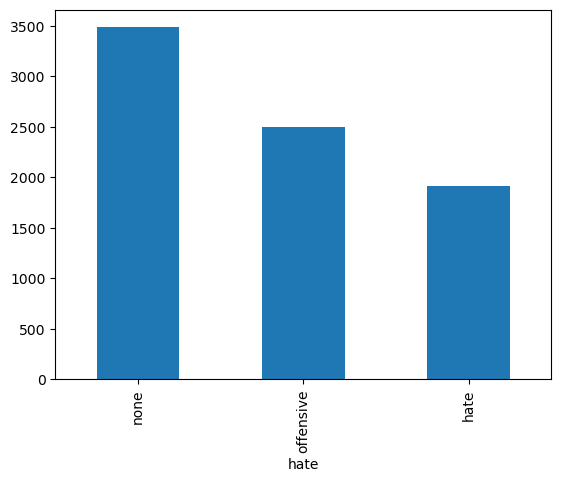

In [83]:
korean_hate_counts = korean_data['hate'].value_counts()
korean_hate_counts.plot.bar()

# fine_tuning BERT

In [19]:
multi_class = multi_class.rename(columns={'multi_class': 'label'})

train_test = Dataset.from_pandas(berkeley_compressed).train_test_split(test_size=0.1)

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def preprocess(examples):
    return tokenizer(examples["text"], truncation=True) 

tokenized_data = train_test.map(preprocess, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/49438 [00:00<?, ? examples/s]

Map:   0%|          | 0/5494 [00:00<?, ? examples/s]

## training arguments 

In [21]:
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=15)


accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")
precision = evaluate.load("precision")
recall = evaluate.load("recall")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

training_args = TrainingArguments(
    output_dir="hatespeech_classifier",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/scratch/slurm-14097/ipykernel_117425/2210602446.py:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [22]:
trainer.train()

ValueError: The model did not return a loss from the inputs, only the following keys: logits. For reference, the inputs it received are input_ids,attention_mask.

# training multi_lable BERT


In [10]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast
from datasets import Dataset, Features, Value, ClassLabel, Sequence
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoConfig

#berkeley_compressed = berkeley_compressed.rename(columns={'hatespeech': 'label'})
berkeley_compressed[demographic_labels] = berkeley_compressed[demographic_labels].astype(int)
berkeley_compressed['labels'] = berkeley_compressed[demographic_labels].astype(float).values.tolist()
train_test = Dataset.from_pandas(berkeley_compressed).train_test_split(test_size=0.1)



#tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")




shortened_berkeley = berkeley_compressed.head(100)
shortened_berkeley["labels"] = shortened_berkeley["labels"].apply(lambda x: np.array(x, dtype=np.int64))
shortened_berkeley = shortened_berkeley[["text", "labels"]]
torch.cuda.empty_cache()

features = Features({
    "text": Value("string"),
    "labels": Sequence(Value("float32"))  
})



shortened_train_test = Dataset.from_pandas(berkeley_compressed).train_test_split(test_size=0.1)
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")


def preprocess(examples):
    tokenized = tokenizer(examples["text"], truncation=True) 
    tokenized["labels"] = examples["labels"]
    return tokenized

tokenized_data = train_test.map(preprocess, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

shortened_tokenized_data = shortened_train_test.map(preprocess, batched = True)


/scratch/slurm-14064/ipykernel_76594/3649219314.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shortened_berkeley["labels"] = shortened_berkeley["labels"].apply(lambda x: np.array(x, dtype=np.int64))


Map:   0%|          | 0/122000 [00:00<?, ? examples/s]

Map:   0%|          | 0/13556 [00:00<?, ? examples/s]

Map:   0%|          | 0/122000 [00:00<?, ? examples/s]

Map:   0%|          | 0/13556 [00:00<?, ? examples/s]

In [11]:
shortened_berkeley = berkeley_compressed.head(100)
shortened_berkeley["labels"] = shortened_berkeley["labels"].apply(lambda x: np.array(x, dtype=np.int64))
shortened_berkeley = shortened_berkeley[["text", "labels"]]
torch.cuda.empty_cache()

features = Features({
    "text": Value("string"),
    "labels": Sequence(Value("float32"))  
})

/scratch/slurm-14064/ipykernel_76594/2049454021.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shortened_berkeley["labels"] = shortened_berkeley["labels"].apply(lambda x: np.array(x, dtype=np.int64))


In [24]:


model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=20, problem_type="multi_label_classification")


accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")
precision = evaluate.load("precision")
recall = evaluate.load("recall")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = torch.sigmoid(torch.tensor(logits))
    preds = (probs > 0.5).int().numpy()
    return {
        "f1_micro": f1.compute(predictions=preds, references=labels, average="micro")["f1"],
        "precision_micro": precision.compute(predictions=preds, references=labels, average="micro")["precision"],
        "recall_micro": recall.compute(predictions=preds, references=labels, average="micro")["recall"],
    }

training_args = TrainingArguments(
    output_dir="hatespeech_classifier",
    learning_rate=4e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="none",
    warmup_ratio=0.1
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    #compute_metrics=compute_metrics,
)
#torch.mps.empty_cache()

trainer.train()

#results = trainer.evaluate(tokenized_data['test'])
#pd.DataFrame(results, index=['Fine-tuned DistilBERT'])

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/scratch/slurm-14064/ipykernel_76594/1718452880.py:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss
1,0.093100,0.092587
2,0.084400,0.089761
3,0.078600,0.090460
4,0.072900,0.093913
5,0.065400,0.097674


TrainOutput(global_step=38125, training_loss=0.0879882236918465, metrics={'train_runtime': 3062.4352, 'train_samples_per_second': 199.188, 'train_steps_per_second': 12.449, 'total_flos': 1.5802946869776e+16, 'train_loss': 0.0879882236918465, 'epoch': 5.0})

# classifying text

## general

In [43]:
def predict_category(text):
    predict_input = tokenizer.encode(text,
    truncation=True,
    padding=True,
    return_tensors="tf")
    output = model(predict_input)[0]
    prediction_value = tf.argmax(output, axis=1).numpy()[0]
    return prediction_value

In [ ]:
unlabelled_data = unlabelled_df[‘data’].to_list()
len(unlabelled_data)

In [ ]:
unlabelled_predictions = []
for data in unlabelled_data:
    unlabelled_predictions.append(predict_category(data))
    prediction_df = pd.DataFrame({
        "data": unlabelled_data,
        "labels": unlabelled_predictions,
    })
prediction_df.to_csv("model_prediction.csv", index=False)

## arabic

In [35]:
arabic_en = arabic_data['english'].to_list()
len(arabic_en)

5846

In [44]:
arabic_predictions = []
for data in arabic_en:
    arabic_predictions.append(predict_category(data))
    arabic_prediction_df = pd.DataFrame({
        "english": arabic_en,
        "labels": arabic_predictions,
    })
prediction_df.to_csv("model_prediction.csv", index=False)

TypeError: list indices must be integers or slices, not tuple

## german

In [ ]:
german_list = german[‘english’].to_list()
len(korean_list)

## korean

In [ ]:
korean_list = korean[‘english’].to_list()
len(korean_list)

# practice code

In [22]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=shortened_tokenized_data["train"],
    eval_dataset=shortened_tokenized_data["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)
#torch.mps.empty_cache()
trainer.train()



#result = trainer.evaluate(shortened_tokenized_data['test'])
#short_results = []
#for item in shortened_tokenized_data['test']:
    #result = trainer.evaluate(item)
    #print(result)
    #short_results.append(result)
    
pd.DataFrame(short_results, index=['Fine-tuned DistilBERT'])

/scratch/slurm-14064/ipykernel_76594/40129132.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


ValueError: Predictions and/or references don't match the expected format.
Expected format: {'predictions': Value(dtype='int32', id=None), 'references': Value(dtype='int32', id=None)},
Input predictions: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]],
Input references: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 1. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]

In [6]:
shortened_berkeley = berkeley_compressed.head(100)
shortened_berkeley["labels"] = shortened_berkeley["labels"].apply(lambda x: np.array(x, dtype=np.int64))
shortened_berkeley = shortened_berkeley[["text", "labels"]]
torch.cuda.empty_cache()

features = Features({
    "text": Value("string"),
    "labels": Sequence(Value("float32"))  
})

NameError: name 'np' is not defined

In [39]:
train_test_short = Dataset.from_pandas(shortened_berkeley, features=features).train_test_split(test_size=0.1)
tokenizer_short = AutoTokenizer.from_pretrained("distilbert-base-uncased")


In [40]:
def preprocess(examples):
    tokenized = tokenizer_short(examples["text"], truncation=True, padding=True) 

    labels = examples["labels"]
    labels = np.array(labels).astype(np.float32)
    
    tokenized["labels"] = torch.tensor(labels, dtype=torch.float)
    
    return tokenized

In [41]:
tokenized_data_short = train_test_short.map(preprocess, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer_short)

Map:   0%|          | 0/90 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

In [19]:
print(tokenized_data_short["train"][0])
config = AutoConfig.from_pretrained(
    "distilbert-base-uncased",
    num_labels=20,
    problem_type="multi_label_classification"
)


{'text': "Question: These 4 broads who criticize America, what country did they flee to get here? And now they want to make OUR America like THEIR former HELL HOLE. I don't think so!!!!!!!!!!  Let them explain their GRATITUDE for letting them in OUR country.", 'labels': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], 'input_ids': [101, 3160, 1024, 2122, 1018, 5041, 2015, 2040, 6232, 4697, 2637, 1010, 2054, 2406, 2106, 2027, 10574, 2000, 2131, 2182, 1029, 1998, 2085, 2027, 2215, 2000, 2191, 2256, 2637, 2066, 2037, 2280, 3109, 4920, 1012, 1045, 2123, 1005, 1056, 2228, 2061, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 2292, 2068, 4863, 2037, 15531, 2005, 5599, 2068, 1999, 2256, 2406, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [20]:
model_short = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    config=config
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:

f1 = evaluate.load("f1")
precision = evaluate.load("precision")
recall = evaluate.load("recall")

In [23]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    logits = torch.tensor(logits, dtype=torch.float).cpu()  
    labels = torch.tensor(labels, dtype=torch.float).cpu()

    probs = torch.sigmoid(torch.tensor(logits))
    preds = (probs > 0.5).int().numpy()
    labels = np.array(labels)

  
    return {
        "f1_micro": f1.compute(predictions=preds, references=labels, average="micro")["f1"],
        "precision_micro": precision.compute(predictions=preds, references=labels, average="micro")["precision"],
        "recall_micro": recall.compute(predictions=preds, references=labels, average="micro")["recall"],
    }

In [29]:


training_args = TrainingArguments(
    output_dir="hatespeech_classifier",
    learning_rate=4e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="none",
    warmup_ratio=0.1
)

trainer_short = Trainer(
    model=model_short,
    args=training_args,
    train_dataset=tokenized_data_short["train"],
    eval_dataset=tokenized_data_short["test"],
    tokenizer=tokenizer_short,
    data_collator=data_collator,
    #compute_metrics=compute_metrics,
)

for batch in trainer_short.get_train_dataloader():
    print(batch)
    break
trainer_short.train()




/scratch/slurm-14062/ipykernel_78845/2188472962.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_short = Trainer(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


{'labels': tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0.],
        [0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0.],

Epoch,Training Loss,Validation Loss
1,No log,0.448916


TrainOutput(global_step=6, training_loss=0.4757084051767985, metrics={'train_runtime': 20.6264, 'train_samples_per_second': 4.363, 'train_steps_per_second': 0.291, 'total_flos': 2585496315600.0, 'train_loss': 0.4757084051767985, 'epoch': 1.0})

In [30]:
for batch in trainer_short.get_train_dataloader():
    print(batch)
    break
trainer_short.train()

{'labels': tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0.],
        [0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0.],

Epoch,Training Loss,Validation Loss
1,No log,0.411055


TrainOutput(global_step=6, training_loss=0.43312708536783856, metrics={'train_runtime': 21.1811, 'train_samples_per_second': 4.249, 'train_steps_per_second': 0.283, 'total_flos': 2585496315600.0, 'train_loss': 0.43312708536783856, 'epoch': 1.0})

In [27]:
#for model_inputs, gold_standards in evaluation_dataset:
 #   predictions = model(model_inputs)
#  metric.add_batch(references=gold_standards, predictions=predictions)
#metric.compute()


accuracy = evaluate.load('accuracy')

#accuracy.description


'\nAccuracy is the proportion of correct predictions among the total number of cases processed. It can be computed with:\nAccuracy = (TP + TN) / (TP + TN + FP + FN)\n Where:\nTP: True positive\nTN: True negative\nFP: False positive\nFN: False negative\n'

In [25]:
#for model_inputs, gold_standards in evaluation_dataset:
 #   predictions = model(model_inputs)
#  metric.add_batch(references=gold_standards, predictions=predictions)
#metric.compute()


accuracy = evaluate.load('accuracy')


results = trainer_short.evaluate(tokenized_data_short['test'])
pd.DataFrame(results, index=['Fine-tuned DistilBERT'])

/scratch/slurm-14062/ipykernel_78845/1874909447.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  probs = torch.sigmoid(torch.tensor(logits))


ValueError: Predictions and/or references don't match the expected format.
Expected format: {'predictions': Value(dtype='int32', id=None), 'references': Value(dtype='int32', id=None)},
Input predictions: [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]],
Input references: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.]]